In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
df_kodex = pd.read_excel("crawled_data_kodex.xlsx")
df_kodex = df_kodex.loc[:, ["date", "KODEX_CLS", "KODEX_OPN", "KODEX_GAP"]]
df_kodex

In [ ]:
df_kodex_inv = pd.read_excel("crawled_data_kodex_inv.xlsx")
df_kodex_inv = df_kodex_inv.loc[:, ["date", "KODEX_INV_CLS", "KODEX_INV_OPN", "KODEX_INV_GAP"]]
df_kodex_inv

In [ ]:
df_kospi = pd.read_excel("crawled_data.xlsx")
df_kospi.dropna(inplace=True)
df_kospi.sort_values("date", inplace=True)
df_kospi.reset_index(drop=True, inplace=True)
df_kospi = df_kospi.iloc[:, 1:6]
df_kospi

In [ ]:
#2021년 데이터로 학습한다.
df = df_kospi.merge(df_kodex, how="right", on="date")
df = df.merge(df_kodex_inv, how="left", on="date")
df.dropna(inplace=True)
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)

df["date"] = pd.to_datetime(df["date"])
df = df[(df["date"] >= "2021-01-01") & (df["date"] <= "2021-12-31")]
df.reset_index(drop=True, inplace=True)
df

In [ ]:
state_list = []
for idx in range(len(df)):
    if idx > 59:
        this_mat = df.iloc[idx-60:idx, 0:5].to_numpy()
        for col_idx in range(1, this_mat.shape[1]):
            this_arr = this_mat[:, col_idx]
            max_val = max(this_arr)
            min_val = min(this_arr)
            for row_idx, val in enumerate(this_arr):
                new_val = (val - min_val) / (max_val - min_val)
                this_mat[row_idx, col_idx] = new_val
        state_list.append(this_mat)

state_list = np.array(state_list)
state_list.shape

#6개열 : date, KOSPI, KOSPI_START, KOSPI_HIGH, KOSPI_LOW, CAPITAL

In [ ]:
action_names = ["KDX매수", "KDI매수"]

In [ ]:
model_pred = tf.keras.Sequential([
    tf.keras.layers.Input((state_list.shape[1]*(state_list.shape[2]-1))+1),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=2, activation="softmax")
])
model_pred.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss="mse", 
              metrics=["mae", "mse"])

model_pred.summary()
model_pred.save("model_pred.h5")
model_q = tf.keras.models.load_model("model_pred.h5")

In [ ]:
from IPython.display import clear_output

dis = .5 #discounted reward를 위해
profit_rate_goal = 1.5 #terminal 목표를 수익율 150%로 설정한다.
update_period = 120 #스테이지 120회당 1번씩 pred 모델의 웨이트를 업데이트 한다.
copy_period = 180
cnt_for_update = 0
cnt_for_copy = 0
episodes = 5000
batch_buffer = []
reward_list = []
result = []
temp_var = False
for episode in range(1, episodes+1):
    clear_output(wait=True)
    
    #변수 초기화
    capital = 1000 * 10000 #천만원으로 시작
    remain_cash = capital
    done = False

    for state_idx, state in enumerate(state_list):
        cnt_for_update += 1
        cnt_for_copy += 1

        #update_period 횟수가 되면 pred 모델을 학습시키고 저장한다.
        if cnt_for_update+1 == update_period:
            batch_buffer = np.array(batch_buffer, dtype=np.float64)
            batch_buffer = batch_buffer.reshape(batch_buffer.shape[0], batch_buffer.shape[2])

            reward_list = np.array(reward_list, dtype=np.float64)
            batch_list = np.hstack([batch_buffer, reward_list])
            training_data = batch_list
            
            # training_data = []
            # sample_idx = np.random.choice(batch_list.shape[0], 32)
            # for idx in sample_idx:
            #     training_data.append(batch_list[idx])
            # training_data = np.array(training_data)

            model_pred.fit(training_data[:, :-2], training_data[:, -2:], verbose=0, batch_size=32)
            model_pred.save("model_pred.h5")
            batch_buffer = [] #업데이트 한 후 미니배치(x)를 초기화한다.
            reward_list = [] #업데이트 한 후 보상값(y)을 초기화한다.
            cnt_for_update = 0
            # print("모델 업데이트")

        #특정 시점(copy_period)가 되면 q모델을 pred모델로부터 복제해 온다.
        if cnt_for_copy+1 == copy_period:
            model_q = tf.keras.models.load_model("model_pred.h5")
            cnt_for_copy = 0
            # print("모델 복제")

        #현재 스테이트의 정보를 불러온다. (60행 * 4열)
        state_data = np.array(state[:, 1:], dtype=np.float64)

        #flatten => 240행
        state_data = state_data.reshape(state_data.shape[0]*state_data.shape[1])

        #현재 수익율(=잔고)을 마지막 요소로 입력 => 241행 / 추후 액션 갯수를 더 늘리기 위해 작업해 놓는것... (매도/홀딩 액션 감안)
        state_data = np.append(state_data, remain_cash / capital)
        state_data = np.expand_dims(state_data, 0)
        batch_buffer.append(state_data) #pred 학습을 위해 먼저 미니배치 버퍼에 x를 넣어놓는다.

        #Q 모델에게 물어본다.
        pred = model_q.predict(state_data)
        action_selected = np.argmax(pred[0])
        action_name_org = action_names[action_selected]

        #exploration을 위해 에피소드 초기에는 랜덤하게 액션을 선택하게 한다.
        e = 1. / (((episode*0.6) / 100) + 1)
        if np.random.rand(1) < e:
            action_selected = random.randrange(0, 2)
        action_name = action_names[action_selected]

        #다음날의 데이터를 불러온다.
        snd_state_idx = df.loc[(df["date"] == state[-1, 0])].index[0] + 1
        sec_state_data = df.loc[snd_state_idx]

        #액션별 수익을 계산한다.
        buy_cnt_kdx = np.floor(remain_cash / sec_state_data["KODEX_OPN"])
        profit_kdx = (buy_cnt_kdx * (sec_state_data["KODEX_CLS"] - sec_state_data["KODEX_OPN"]))
        remain_cash_kdx = remain_cash + profit_kdx
        snd_profit_rate_kdx = remain_cash_kdx / capital
        reward_kdx = (snd_profit_rate_kdx - (1 - profit_rate_goal)) / (profit_rate_goal - (1-profit_rate_goal))

        buy_cnt_kdi = np.floor(remain_cash / sec_state_data["KODEX_INV_OPN"])
        profit_kdi = (buy_cnt_kdi * (sec_state_data["KODEX_INV_CLS"] - sec_state_data["KODEX_INV_OPN"]))
        remain_cash_kdi = remain_cash + profit_kdi
        snd_profit_rate_kdi = remain_cash_kdi / capital
        reward_kdi = (snd_profit_rate_kdi - (1 - profit_rate_goal)) / (profit_rate_goal - (1-profit_rate_goal))

        #액션을 취하고 액션별 수익을 반영한다. (다음날 시작 가격으로 매수 혹은 매도)
        if action_name == "KDX매수":
            profit = profit_kdx
            remain_cash = remain_cash_kdx
            reward = reward_kdx
        elif action_name == "KDI매수":
            profit = profit_kdi
            remain_cash = remain_cash_kdi
            reward = reward_kdi

        #수익율을 계산해 본다.
        snd_profit_rate = remain_cash / capital

        if state_idx == len(state_list)-2: #마지막 스테이트라면 (실제로는 마지막 스테이트 이전이지만)
            done = True
        else:
            #수익율이 상한선에 다다르면 reward는 2, 하한선에 다달았다면 reward를 0으로 주고 에피소드를 종료한다.
            if snd_profit_rate >= profit_rate_goal:
                reward = 2
                done = True
            elif snd_profit_rate <= 0.99: #하한선을 0.99로 한다
                reward = 0
                done = True
            else:
                #이틀 뒤의 데이터를 불러온다.
                trd_state_data = state_list[state_idx+2]

                #model_q에 물어봐서 이틀뒤의 가장 높은 이익을 구해 보상값을 업데이트해 준다.
                trd_state_data = trd_state_data[:, 1:]

                #flatten => 1행 240열
                trd_state_data = trd_state_data.reshape(trd_state_data.shape[0]*trd_state_data.shape[1])

                #현재 수익율을 마지막 요소로 입력 => 241행
                trd_state_data = np.append(trd_state_data, remain_cash / capital)
                trd_state_data = np.expand_dims(trd_state_data, 0)
                trd_state_data = trd_state_data.astype(float)

                trd_pred = model_q.predict(trd_state_data)
                trd_reward = np.max(trd_pred[0]) #0~1사이 값으로 출력될 것
                reward = reward + (dis * trd_reward)
                # if reward > 1: #제한을 걸어야 하나 말아야 하나...
                #     reward = 1

        if action_name == "KDX매수":
            this_reward_list = [reward, reward_kdi]
            
        elif action_name == "KDI매수":
            this_reward_list = [reward_kdx, reward]

        #보상을 reward_list에 반영한다. (y값이 될 것)
        reward_list.append(this_reward_list)

        # print("\n\n[EPISODE{}, S{} : {} → {}] {} {}".format(
        #     episode, state_idx, action_name_org, action_name, pred[0], this_reward_list), end="\r")
        print("\n\n[EPISODE{}, S{}] {} {}".format(
            episode, state_idx, pred[0], this_reward_list), end="\r")        
        print("\n잔고 : {:,d}원".format(int(remain_cash), end="\r"))

        if done is True:
            result.append({
                "EPISODE" : episode,
                "MAX. STATE" : state_idx,
                "잔고" : remain_cash,
                "수익" : remain_cash - capital,
                "수익율" : remain_cash / capital
            })
            break

    df_result = pd.DataFrame(result)
    df_result.to_excel("result.xlsx", index=False)

# 추론 / 테스트 데이터에 적용

In [35]:
#2020년 데이터로 추론해 본다.
df_test = df_kospi.merge(df_kodex, how="right", on="date")
df_test = df_test.merge(df_kodex_inv, how="left", on="date")
df_test.dropna(inplace=True)
df_test.sort_values("date", inplace=True)
df_test.reset_index(drop=True, inplace=True)

df_test["date"] = pd.to_datetime(df_test["date"])
df_test = df_test[(df_test["date"] >= "2021-01-01") & (df_test["date"] <= "2021-12-31")]
df_test.reset_index(drop=True, inplace=True)
df_test

,date,KOSPI,KOSPI_START,KOSPI_HIGH,KOSPI_LOW,KODEX_CLS,KODEX_OPN,KODEX_GAP,KODEX_INV_CLS,KODEX_INV_OPN,KODEX_INV_GAP
0,2021-01-04,2944.45,2874.50,2946.54,2869.11,29850,29320,-530,4145.0,4260.0,115.0
1,2021-01-05,2990.57,2943.67,2990.57,2921.84,30340,29790,-550,4090.0,4175.0,85.0
2,2021-01-06,2968.21,2993.34,3027.16,2961.37,30195,30490,295,4125.0,4080.0,-45.0
3,2021-01-07,3031.68,2980.75,3055.28,2980.75,30830,30515,-315,4030.0,4075.0,45.0
4,2021-01-08,3152.18,3040.11,3161.11,3040.11,31955,31185,-770,3850.0,3980.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...
235,2021-12-23,2998.17,2998.02,3000.70,2980.91,30155,30200,45,4005.0,4015.0,10.0
236,2021-12-27,2999.55,3013.94,3017.31,2999.30,30235,30365,130,4000.0,3975.0,-25.0
237,2021-12-28,3020.24,3006.77,3020.29,2991.55,30445,30250,-195,3980.0,3990.0,10.0
238,2021-12-29,2993.29,3002.90,3007.72,2988.67,30545,30560,15,3980.0,3965.0,-15.0


In [36]:
state_list = []
for idx in range(len(df_test)):
    if idx > 59:
        this_mat = df_test.iloc[idx-60:idx, 0:5].to_numpy()
        for col_idx in range(1, this_mat.shape[1]):
            this_arr = this_mat[:, col_idx]
            max_val = max(this_arr)
            min_val = min(this_arr)
            for row_idx, val in enumerate(this_arr):
                new_val = (val - min_val) / (max_val - min_val)
                this_mat[row_idx, col_idx] = new_val
        state_list.append(this_mat)

state_list = np.array(state_list)
state_list.shape

#6개열 : date, KOSPI, KOSPI_START, KOSPI_HIGH, KOSPI_LOW, CAPITAL

(180, 60, 5)

In [40]:
model = tf.keras.models.load_model("model_pred_1.5.h5")
action_names = ["KDX매수", "KDI매수"]
capital = 1000 * 10000
remain_cash = capital
result = []
for state_idx, state in enumerate(state_list):
    #현재 스테이트의 정보를 불러온다. (60행 * 4열)
    state_data = np.array(state[:, 1:], dtype=np.float64)

    #flatten => 240행
    state_data = state_data.reshape(state_data.shape[0]*state_data.shape[1])

    #현재 수익율(=잔고)을 마지막 요소로 입력 => 241행 / 추후 액션 갯수를 더 늘리기 위해 작업해 놓는것... (매도/홀딩 액션 감안)
    state_data = np.append(state_data, remain_cash / capital)
    state_data = np.expand_dims(state_data, 0)

    #Q 모델에게 물어본다.
    pred = model.predict(state_data)
    action_selected = np.argmax(pred[0])
    action_name = action_names[action_selected]
    # print("STATE {} : {}".format(state_idx, action_name))

    #다음날의 데이터를 불러온다.
    snd_state_idx = df_test.loc[(df_test["date"] == state[-1, 0])].index[0] + 1
    sec_state_data = df_test.loc[snd_state_idx]

    #액션별 수익을 계산한다.
    buy_cnt_kdx = np.floor(remain_cash / sec_state_data["KODEX_OPN"])
    profit_kdx = (buy_cnt_kdx * (sec_state_data["KODEX_CLS"] - sec_state_data["KODEX_OPN"]))
    remain_cash_kdx = remain_cash + profit_kdx

    buy_cnt_kdi = np.floor(remain_cash / sec_state_data["KODEX_INV_OPN"])
    profit_kdi = (buy_cnt_kdi * (sec_state_data["KODEX_INV_CLS"] - sec_state_data["KODEX_INV_OPN"]))
    remain_cash_kdi = remain_cash + profit_kdi

    #액션을 취하고 액션별 수익을 반영한다. (다음날 시작 가격으로 매수 혹은 매도)
    if action_name == "KDX매수":
        profit = profit_kdx
        remain_cash = remain_cash_kdx
    elif action_name == "KDI매수":
        profit = profit_kdi
        remain_cash = remain_cash_kdi

    #수익율을 계산해 본다.
    snd_profit_rate = remain_cash / capital

    result.append({
        "STATE" : state_idx,
        "잔고" : remain_cash,
        "수익" : remain_cash - capital,
        "수익율" : remain_cash / capital
    })

df_result = pd.DataFrame(result)
df_result.to_excel("result_test.xlsx", index=False)
df_result

Exception ignored in: <function ZipFile.__del__ at 0x000001F8FF8CDC10>
Traceback (most recent call last):
  File "C:\Users\poscohrd\AppData\Local\Programs\Python\Python38\lib\zipfile.py", line 1821, in __del__
    self.close()
  File "C:\Users\poscohrd\AppData\Local\Programs\Python\Python38\lib\zipfile.py", line 1838, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


,STATE,잔고,수익,수익율
0,0,10052480.0,52480.0,1.005248
1,1,10039340.0,39340.0,1.003934
2,2,10026235.0,26235.0,1.002623
3,3,10078655.0,78655.0,1.007866
4,4,10104935.0,104935.0,1.010493
...,...,...,...,...
175,175,12041965.0,2041965.0,1.204196
176,176,11990485.0,1990485.0,1.199048
177,177,12067705.0,2067705.0,1.206770
178,178,12113350.0,2113350.0,1.211335


<AxesSubplot:>

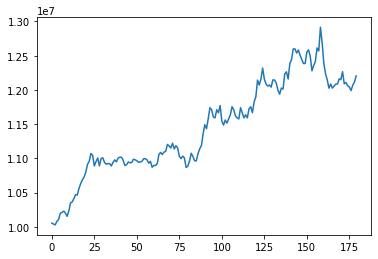

In [41]:
df_result["잔고"].plot()